In [1942]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
df = pd.read_csv("SPY.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'] > '2016-01-01']
#df = df.reset_index(inplace = True)
df = df.reset_index(drop = True)
#df.set_index('Date', inplace=True)

In [1943]:


delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)
window = 14
avg_gain = gain.rolling(window=window, min_periods=1).mean()
avg_loss = loss.rolling(window=window, min_periods=1).mean()
RS = avg_gain / avg_loss
RSI = 100 - (100 / (1 + RS))
df['RSI14'] = RSI
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)
window = 7
avg_gain = gain.rolling(window=window, min_periods=1).mean()
avg_loss = loss.rolling(window=window, min_periods=1).mean()
RS = avg_gain / avg_loss
RSI = 100 - (100 / (1 + RS))
df['RSI7'] = RSI
indices_to_drop = df.index[:20]
df = df.drop(indices_to_drop).reset_index(drop=True)



In [1944]:
df['Day_of_Week'] = df['Date'].dt.day_name()
df['Month_of_Year'] = df['Date'].dt.month

In [1945]:
df2 = pd.read_csv("^VIX.csv")
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2[['Date', 'Close']]
df2 = df2.rename(columns={'Close':'VIX_Close'})
df3 = pd.read_csv("^TNX.csv")
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3[['Date', 'Close']]
df3 = df3.rename(columns={'Close':'TNX_Close'})
df4 = pd.read_csv("^TYX.csv")
df4['Date'] = pd.to_datetime(df4['Date'])
df4 = df4[['Date', 'Close']]
df4 = df4.rename(columns={'Close':'TYX_Close'})
merged_df = pd.merge(df2, df3, on='Date', how='inner')
merged_df1 = pd.merge(merged_df, df4, on='Date', how='inner')

In [1946]:
df = pd.merge(df, merged_df1, on='Date',how='left')

In [1947]:
df.replace(0, np.nan, inplace=True)
df = df.dropna()
df = df.reset_index(drop = True)
df['Day_of_Week'] = df['Day_of_Week'].astype('category').cat.codes
split_idx = int(len(df) * .85)
df['Date'] = df['Date'].astype('category').cat.codes
scaler = MinMaxScaler()
features = ['Close','Date', 'Open', 'High', 'Low', 'Volume', 'RSI14', 'RSI7', 'Day_of_Week', 'Month_of_Year', 'VIX_Close', 'TNX_Close', 'TYX_Close']
#display(df)
df[features] = scaler.fit_transform(df[features])
df = df[['Close','Date', 'Open', 'High', 'Low', 'Volume', 'RSI14', 'RSI7', 'Day_of_Week', 'Month_of_Year', 'VIX_Close', 'TNX_Close', 'TYX_Close']]
train = df[:split_idx]
test = df[split_idx:]

In [1948]:
def sequence(data, length):
    xs = []
    ys = []
    for i in range(len(data)-length):
        x = data[features].iloc[i:(i+length)]
        y = data.iloc[i+length]['Close']
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [1949]:
seq = 4 
train_X, train_y = to_sequences(train, seq)
test_X, test_y = to_sequences(test, seq)
train_X.shape

(1753, 4, 13)

In [1950]:
import torch
from torch.utils.data import TensorDataset, DataLoader
X_torch = torch.tensor(train_X, dtype=torch.float32)
y_torch = torch.tensor(train_y, dtype=torch.float32).view(-1, 1)
train_data = TensorDataset(X_torch, y_torch)
train_loader = DataLoader(train_data, batch_size=512, shuffle=False)

In [1951]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input, hl, out):
        super(LSTM, self).__init__()
        self.hl = hl
        self.lstm = nn.LSTM(input, hl, batch_first=True)
        self.linear = nn.Linear(hl, out)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

input = len(features)
hl = 50
out = 1

model = LSTM(input, hl, out)


In [1952]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

epochs = 50
for epoch in range(epochs):
    for seqs, labels in train_loader:
        optimizer.zero_grad()
        y_pred = model(seqs)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1} Loss: {loss.item()}')

Epoch 1 Loss: 0.4928416609764099
Epoch 2 Loss: 0.284860223531723
Epoch 3 Loss: 0.11554954200983047
Epoch 4 Loss: 0.015618623234331608
Epoch 5 Loss: 0.01253702212125063
Epoch 6 Loss: 0.010233375243842602
Epoch 7 Loss: 0.006080007646232843
Epoch 8 Loss: 0.016954056918621063
Epoch 9 Loss: 0.02265898510813713
Epoch 10 Loss: 0.016915787011384964
Epoch 11 Loss: 0.0076331947930157185
Epoch 12 Loss: 0.003285446669906378
Epoch 13 Loss: 0.003015348222106695
Epoch 14 Loss: 0.0024910965003073215
Epoch 15 Loss: 0.002383507788181305
Epoch 16 Loss: 0.002403323771432042
Epoch 17 Loss: 0.0015800361288711429
Epoch 18 Loss: 0.0015855380333960056
Epoch 19 Loss: 0.0019019718747586012
Epoch 20 Loss: 0.0012474842369556427
Epoch 21 Loss: 0.0009063005563803017
Epoch 22 Loss: 0.0010378527222201228
Epoch 23 Loss: 0.0013351006200537086
Epoch 24 Loss: 0.0010789547814056277
Epoch 25 Loss: 0.0007887305691838264
Epoch 26 Loss: 0.0007548806024715304
Epoch 27 Loss: 0.0008080091211013496
Epoch 28 Loss: 0.000753522035665

Mean Squared Error: 0.00025736819952726364
Mean Absolute Error: 0.012673435732722282


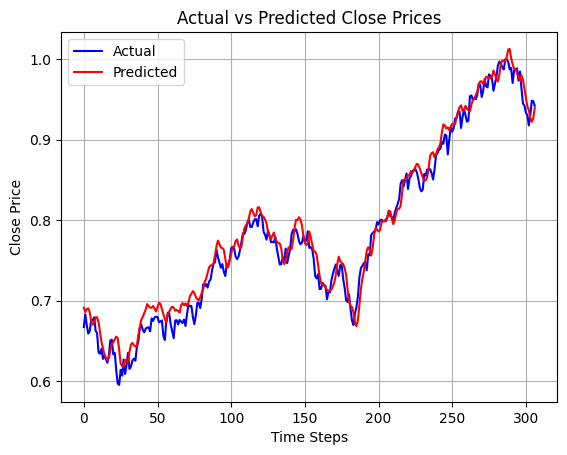

In [1953]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_test_torch = torch.tensor(test_X, dtype=torch.float32)
y_test_torch = torch.tensor(test_y, dtype=torch.float32).view(-1, 1)

test_data = TensorDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_data, batch_size=512, shuffle=False)

model.eval()  
predictions = []
actuals = []

with torch.no_grad():
    for seqs, labels in test_loader:
        output = model(seqs)
        predictions.extend(output.numpy().flatten())  
        actuals.extend(labels.numpy().flatten())  

mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals,predictions)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
import matplotlib.pyplot as plt


#plt.figure(figsize=(10, 6))
plt.plot(actuals[:], label='Actual', color='blue')
plt.plot(predictions[:], label='Predicted', color='red')
plt.grid(2)
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.show()